### DATA

When dealing with image, text audio etc, use standard python packages to load data to numpy and then convert to torch tensor

For images - Pillow, OpenCV
For audio - scipy, librosa
For text - Raw python, nltk, spacy etc


for vision - we have torchvision, in build dataloaders such as Imagenet, CIFAR10, MNIST etc are available  --> torchvision.datasets
data transformers -> torch.utils.data.DataLoader

#### CIFAR10

classes - > 'airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck' 

size --> 3x32x32 --> 3 channel color images of 32x32 pixels

#### Steps for training an image classifier
1. load and normalize data
2. Define the convolutional nn
3. Loss function
4. Train the network on the training data
5. Test the network on test data

In [31]:
#Loading using torchvision
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


Files already downloaded and verified


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [33]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [34]:
import matplotlib.pyplot as plt
import numpy as np

      bird      plane        cat       bird


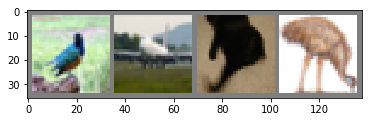

In [35]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5) #3 input channel, 6 output channels, 5x5 square convolution
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Max pool over a (2, 2) window
        x = self.pool(F.relu(self.conv2(x))) #if size is squar we can specify only one number
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [37]:
#loss
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [38]:
#training
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss+= loss.item()
        
        if i%2000 == 1999:
            print(epoch+1, "loss: ", running_loss/2000)
            running_loss = 0.0
print("training finished")

1 loss:  2.2065217568278315
1 loss:  1.8658581896424293
1 loss:  1.6949124454259872
1 loss:  1.5973757745027541
1 loss:  1.5166579952389
1 loss:  1.4568492291122674
2 loss:  1.3971277109831572
2 loss:  1.3470200873166323
2 loss:  1.3432370072454214
2 loss:  1.2923961747139692
2 loss:  1.2906934617459773
2 loss:  1.2599239652305843
training finished


GroundTruth:    cat  ship  ship plane


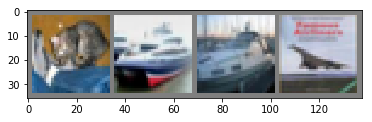

In [39]:
#testing

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
#prediction
outputs = net(images)

In [41]:
_, predicted = torch.max(outputs, 1)

predicted_classes = [classes[predicted[j]] for j in range(4)]
print("prediction: ", predicted_classes)

prediction:  ['cat', 'car', 'car', 'plane']


In [42]:
# Performance on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print("accuracy of network : ", 100 * correct / total)

accuracy of network :  54.01


In [47]:
# accuracy of induvidual classes

# Performance on the whole dataset
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("accuracy of %5s: %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))

accuracy of plane: 52 %
accuracy of   car: 80 %
accuracy of  bird: 57 %
accuracy of   cat: 58 %
accuracy of  deer: 24 %
accuracy of   dog: 33 %
accuracy of  frog: 47 %
accuracy of horse: 68 %
accuracy of  ship: 65 %
accuracy of truck: 52 %
